### Import data

### Citations
#### Dataset
“Stratosphere Laboratory. A labeled dataset with malicious and benign IoT network traffic. January 22th. Parmisano, Sebastian Garcia, Maria Jose Erquiaga. https://www.stratosphereips.org/datasets-iot23



In [1]:
def find_csv_delimiter(file_path, max_lines=5):
    with open(file_path, 'r', newline='') as file:
        sample_lines = [file.readline().strip() for _ in range(max_lines)]

    delimiters = [',', ';', '\t', '|']  # Common delimiters to check

    best_delimiter = ','
    max_delimiter_count = 0

    for delimiter in delimiters:
        delimiter_count = sum(line.count(delimiter) for line in sample_lines)
        if delimiter_count > max_delimiter_count:
            best_delimiter = delimiter
            max_delimiter_count = delimiter_count

    return best_delimiter

import csv
import numpy as np
from sklearn.preprocessing import LabelEncoder

def extract_data_from_csv(file_path, delimiter=','):
    data = []  # Create a list to store the data

    # Open the CSV file for reading
    with open(file_path, mode='r', newline='') as file:
        # Create a CSV reader object with the pipe delimiter

        csv_reader = csv.reader(file, delimiter=delimiter)

        # Read the header row
        header = next(csv_reader)

        # Iterate through the rows in the CSV file
        for row in csv_reader:
            data.append(row)
    
    return data

data = []

import os
cpt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    
        for filename in filenames:
            if cpt < 2:
                file_path = os.path.join(dirname, filename)
                delimiter = find_csv_delimiter(file_path)
                data += extract_data_from_csv(file_path, delimiter)
                print(os.path.join(dirname, filename))
                cpt+=1
            else:
                break
        

# Convert your data to a NumPy array
data = np.array(data)

print(data.shape)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/network-malware-detection-connection-analysis/CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv
/kaggle/input/network-malware-detection-connection-analysis/CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv
(3591431, 23)


In [2]:
print(data[0])

['1533042911.474174' 'C5JLGOoxIw2dBZt47' '192.168.100.113' '123'
 '81.2.254.224' '123' 'udp' '-' '0.005490' '48' '48' 'SF' '-' '-' '0' 'Dd'
 '1' '76' '1' '76' '-' 'Benign' '-']


### Process data

In [3]:
columns_to_remove = [0, 1, 2, 4, 12, 13, 14, 20, 22]

# Remove columns using NumPy's array slicing
data = np.delete(data, columns_to_remove, axis=1)

# Make Malicious = 1 and Benign = 0
for row in data:
    if row[-1] == 'Benign':
        row[-1] = 0
    else:
        row[-1] = 1

columns_to_transform = [3, 4, 5, 6, 8]
# Columns to put 0 if '-'
zeros = [4, 5, 6]
# Replace '-'
for row in data:
    for column in columns_to_transform:
        if row[column] == '-' and column in zeros:
            row[column] = 0
        elif row[column] == '-' and column not in zeros:
            row[column] = 'Unkown'

columns_to_convert_to_float = [4]
# Convert columns to float
for row in data:
    for column in columns_to_convert_to_float:
        row[column] = float(row[column])

columns_to_convert_to_int = [0, 1, 5, 6, 8, 9, 10, 11]

# Convert columns to int
for row in data:
    for column in columns_to_convert_to_int:
        try:
            # Attempt to convert the value to an integer
            row[column] = int(row[column])
        except (ValueError, TypeError):
            pass

# Remove rows where first column contains ip address
rows_to_remove = []
for index, row in enumerate(data):
    # If the first column is an IP address
    if row[0].count('.') == 3:
        rows_to_remove.append(index)

# Delete the rows by index
for index in sorted(rows_to_remove, reverse=True):
    del data[index]

In [4]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# columns_to_onehot = [0, 1, 2, 3, 7, 8]
columns_to_onehot = [2, 3, 7, 8]

print('Before one-hot encoding features:')
print(data[0])
print(data[0].shape)

onehot_encoder = OneHotEncoder(sparse_output=True)

dataCopy = data.copy()

addedCols = 0
for column in columns_to_onehot:
    column_values = data[:, column]
    onehot_encoded = onehot_encoder.fit_transform(column_values.reshape(-1, 1)).toarray()
    dataCopy = np.delete(dataCopy, column + addedCols, axis=1)
    
    # Insert the new columns
    for i, encoded_column in enumerate(onehot_encoded.T):
        dataCopy = np.insert(dataCopy, column + i + addedCols, encoded_column, axis=1)

    addedCols += onehot_encoded.shape[1] - 1

data = dataCopy


print('After one-hot encoding features:')
print(data[0])
print(data[0].shape)
    


Before one-hot encoding features:
['123' '123' 'udp' 'Unkown' '0.00549' '48' '48' 'SF' 'Dd' '1' '76' '1'
 '76' '0']
(14,)
After one-hot encoding features:
['123' '123' '0.0' '0.0' '1.0' '1.0' '0.0' '0.00549' '48' '48' '0.0' '0.0'
 '0.0' '0.0' '0.0' '1.0' '0.0' '0.0' '1.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '1' '76' '1' '76' '0']
(32,)


In [5]:
# Check if any of the data contains strings
for row in data:
    for column in row:
        if isinstance(column, str):
            #Convert the value to a float, if possible
            try:
                column = float(column)
            except ValueError:
                pass

# Initialize an empty list to store preprocessed data
preprocessed_data = []

# Iterate through the rows in the data
for row in data:
    try:
        # Convert all columns to floats in this row
        float_row = [float(column) if column != '-' else 0.0 for column in row]
        preprocessed_data.append(float_row)
    except ValueError:
        print('Skipping row with non-convertible values:', row)

data = preprocessed_data

# Check if data contains strings
for row in data:
    for column in row:
        if isinstance(column, str):
            print('Error: String found in data: ', column)
            break

preprocessed_data = data

# Convert preprocessed_data to a normal Python list of lists
preprocessed_data = [list(row) for row in preprocessed_data]

# # Print the preprocessed data
# for row in preprocessed_data:
#     print(row)


### Separate data

In [6]:
import random
import numpy as np

# Separate data

# Define the split ratios for training, validation, and test datasets
train_ratio = 0.70  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

train_val_indices = int((train_ratio + val_ratio) * len(preprocessed_data))

train_val_data = preprocessed_data[:train_val_indices]
test_data = preprocessed_data[train_val_indices:]

# Shuffle the data randomly
random.shuffle(train_val_data)
random.shuffle(test_data)

# Calculate the split points
total_records = len(train_val_data)
train_split = int(train_ratio * total_records)
val_split = int(val_ratio * total_records)

# Split the data into training, validation
train_data = train_val_data[:train_split]
val_data = train_val_data[train_split:]

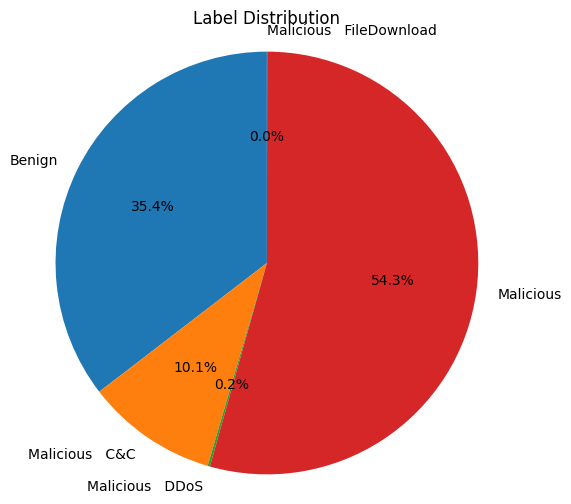

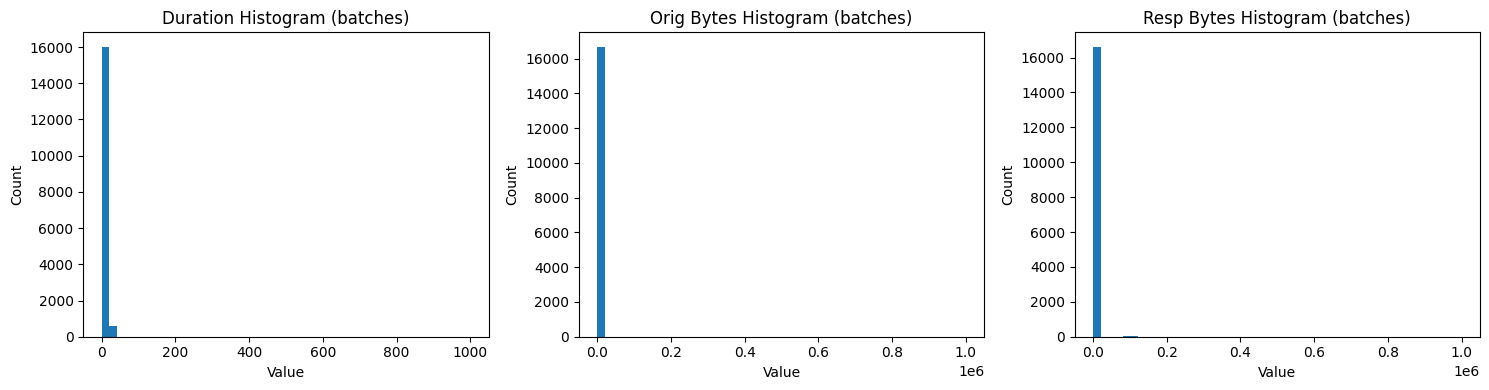

/tmp/ipykernel_32/3550381010.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys, rotation=45, ha='right')


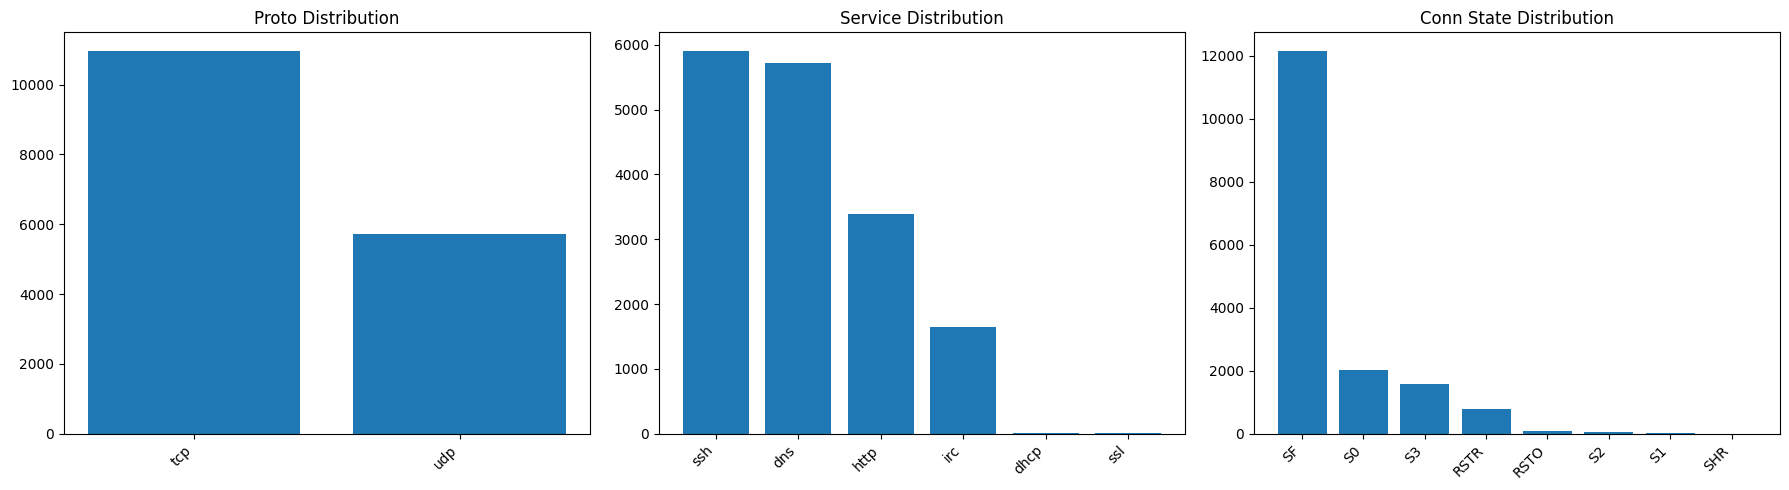

In [7]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from collections import Counter

# Parameters
dir_path = "/kaggle/input/network-malware-detection-connection-analysis/"
batch_size = 100_000  # rows per chunk

# Define bins for numeric histograms
durations = np.linspace(0, 1000, 50)  # adjust to your data range
bytes_bins = np.linspace(0, 1e6, 50)

# Initialize accumulators
hist_counts = {
    'duration': np.zeros(len(durations)-1, dtype=int),
    'orig_bytes': np.zeros(len(bytes_bins)-1, dtype=int),
    'resp_bytes': np.zeros(len(bytes_bins)-1, dtype=int)
}
cat_counters = {col: Counter() for col in ['proto', 'service', 'conn_state']}
label_counter = Counter()
sample_rows = []  # for scatter matrix sampling

# Process each file in chunks
csv_files = glob.glob(dir_path + "/*.csv")
for path in csv_files:
    for chunk in pd.read_csv(path, sep="|", low_memory=False, chunksize=batch_size):
        # Preprocess
        chunk.replace('-', np.nan, inplace=True)
        for col in ['duration', 'orig_bytes', 'resp_bytes']:
            chunk[col] = pd.to_numeric(chunk[col], errors='coerce')
        chunk = chunk.dropna(subset=['proto','service','duration','orig_bytes','resp_bytes','conn_state','label'])
        chunk['label_bin'] = (chunk['label'] != 'Benign').astype(int)

        # Accumulate label counts
        label_counter.update(chunk['label'])

        # Numeric histograms accumulator
        hist_counts['duration'] += np.histogram(chunk['duration'], bins=durations)[0]
        hist_counts['orig_bytes'] += np.histogram(chunk['orig_bytes'], bins=bytes_bins)[0]
        hist_counts['resp_bytes'] += np.histogram(chunk['resp_bytes'], bins=bytes_bins)[0]

        # Categorical counts
        for col in ['proto', 'service', 'conn_state']:
            cat_counters[col].update(chunk[col])

        # Sample rows for scatter plot (e.g., 5% random)
        sample_rows.append(chunk.sample(frac=0.05, random_state=42))

# Combine samples
sample_df = pd.concat(sample_rows, ignore_index=True)

# --- Label Distribution Pie Chart ---
labels, sizes = zip(*label_counter.items())
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.show()

# Plot numeric histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].bar((durations[:-1] + durations[1:]) / 2, hist_counts['duration'], width=np.diff(durations))
axes[0].set_title('Duration Histogram (batches)')
axes[1].bar((bytes_bins[:-1] + bytes_bins[1:]) / 2, hist_counts['orig_bytes'], width=np.diff(bytes_bins))
axes[1].set_title('Orig Bytes Histogram (batches)')
axes[2].bar((bytes_bins[:-1] + bytes_bins[1:]) / 2, hist_counts['resp_bytes'], width=np.diff(bytes_bins))
axes[2].set_title('Resp Bytes Histogram (batches)')
for ax in axes:
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Plot categorical counts
def plot_counter(counter, title, ax):
    items = counter.most_common(20)
    keys, vals = zip(*items)
    ax.bar(keys, vals)
    ax.set_title(title)
    ax.set_xticklabels(keys, rotation=45, ha='right')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_counter(cat_counters['proto'], 'Proto Distribution', axes[0])
plot_counter(cat_counters['service'], 'Service Distribution', axes[1])
plot_counter(cat_counters['conn_state'], 'Conn State Distribution', axes[2])
plt.tight_layout()
plt.show()


In [ ]:
# %%
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from xgboost import XGBClassifier
import joblib

# 1) Read all CSVs with correct delimiter
csv_files = glob.glob("/kaggle/input/network-malware-detection-connection-analysis/*.csv")
df_list = [pd.read_csv(path, sep="|", low_memory=False) for path in csv_files]
df = pd.concat(df_list, ignore_index=True)

# 2) Inspect columns
print("Columns in raw CSV:", df.columns.tolist())

# 3) Select the six unified features + label
FEATURE_ORDER = ['proto','service','duration','orig_bytes','resp_bytes','conn_state']
TARGET        = 'label'
df_model4     = df[FEATURE_ORDER + [TARGET]].copy()

# 4a) Clean numeric columns: replace '-' with NaN, then cast
df_model4.replace('-', np.nan, inplace=True)
for col in ['duration','orig_bytes','resp_bytes']:
    df_model4[col] = pd.to_numeric(df_model4[col], errors='coerce')

# 4b) Map string labels to 0/1
df_model4[TARGET] = (df_model4[TARGET] != 'Benign').astype(int)

# 4c) Drop any rows with missing
df_model4.dropna(subset=FEATURE_ORDER + [TARGET], inplace=True)
print("After cleaning + dropna:", df_model4.shape)
print(df_model4[TARGET].value_counts())

# 5) Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    df_model4[FEATURE_ORDER],
    df_model4[TARGET],
    test_size=0.15,
    random_state=42,
    stratify=df_model4[TARGET]
)

# 6) Build pipeline: encode & scale
preprocessor = ColumnTransformer([
    ("ord",   OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
               ['proto','service','conn_state']),
    ("scale", StandardScaler(), ['duration','orig_bytes','resp_bytes'])
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",   XGBClassifier(
         use_label_encoder=False, eval_metric="logloss", random_state=42
    ))
])

# 7) Fit & save
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, "model_4_pipeline_ordinal.pkl")
print("model_4_pipeline_ordinal.pkl saved.")

# 8) Sanity‐check
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print("Validation accuracy:", accuracy_score(y_val, y_pred))


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define your XGBoost classifier and hyperparameter search space
xgb_model = XGBClassifier()
param_space = {
    'n_estimators': [100],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_space,
    n_iter=5,  # Adjust the number of iterations as needed
    scoring='accuracy',  # Use the appropriate scoring metric
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    cv=5,  # Number of cross-validation folds
    random_state=42,  # Set a random seed for reproducibility
    verbose=3
)

# Perform hyperparameter optimization
random_search.fit(train_data, train_labels)

# Get the best hyperparameters and the best model
best_xgb_hps = random_search.best_params_
best_xgb_model = random_search.best_estimator_


In [ ]:
print(best_xgb_hps)

### Evaluate model on val set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Evaluate the Random Forest model on the validation data
sgboost_val_predictions = random_search.predict(val_data)
sgboost_val_accuracy = np.mean(sgboost_val_predictions == val_labels)
print("Validation Accuracy (Random Forest):", sgboost_val_accuracy)

# Calculate and print classification report and confusion matrix for Random Forest
sgboost_val_report = classification_report(val_labels, sgboost_val_predictions)
sgboost_val_confusion = confusion_matrix(val_labels, sgboost_val_predictions)
print("Validation Classification Report (XGBoost):")
print(sgboost_val_report)
print("Validation Confusion Matrix (XGBoost):")
print(sgboost_val_confusion)


### Evaluate model on test set

In [ ]:
# Evaluate the Random Forest model on the test data
sgboost_test_predictions = random_search.predict(test_data)
sgboost_test_accuracy = np.mean(sgboost_test_predictions == test_labels)
print("Test Accuracy (SGBoost):", sgboost_test_accuracy)

# Calculate and print classification report and confusion matrix for Random Forest
sgboost_test_report = classification_report(test_labels, sgboost_test_predictions)
sgboost_test_confusion = confusion_matrix(test_labels, sgboost_test_predictions)
print("Test Classification Report (XGBoost):")
print(sgboost_test_report)
print("Test Confusion Matrix (XGBoost):")
print(sgboost_test_confusion)